# NGCF Implementation 

Number of Users: 6022, Number of Items: 3043
Epoch 1/10
1556/1556 ━━━━━━━━━━━━━━━━━━━━ 173s 110ms/step - loss: 0.3971
Epoch 1 Loss: 0.397076
Epoch 2/10
1556/1556 ━━━━━━━━━━━━━━━━━━━━ 168s 108ms/step - loss: 0.3392
Epoch 2 Loss: 0.339223
Epoch 3/10
1556/1556 ━━━━━━━━━━━━━━━━━━━━ 169s 108ms/step - loss: 0.3226
Epoch 3 Loss: 0.322649
Epoch 4/10
1556/1556 ━━━━━━━━━━━━━━━━━━━━ 170s 109ms/step - loss: 0.3124
Epoch 4 Loss: 0.312407
Epoch 5/10
1556/1556 ━━━━━━━━━━━━━━━━━━━━ 167s 107ms/step - loss: 0.3057
Epoch 5 Loss: 0.305673
Epoch 6/10
1556/1556 ━━━━━━━━━━━━━━━━━━━━ 170s 109ms/step - loss: 0.3010
Epoch 6 Loss: 0.300988
Epoch 7/10
1556/1556 ━━━━━━━━━━━━━━━━━━━━ 168s 107ms/step - loss: 0.2972
Epoch 7 Loss: 0.297151
Epoch 8/10
1556/1556 ━━━━━━━━━━━━━━━━━━━━ 169s 108ms/step - loss: 0.2940
Epoch 8 Loss: 0.294027
Epoch 9/10
1556/1556 ━━━━━━━━━━━━━━━━━━━━ 170s 109ms/step - loss: 0.2922
Epoch 9 Loss: 0.292226
Epoch 10/10
1556/1556 ━━━━━━━━━━━━━━━━━━━━ 166s 107ms/step - loss: 0.2912
Epoch 10 Loss: 0.

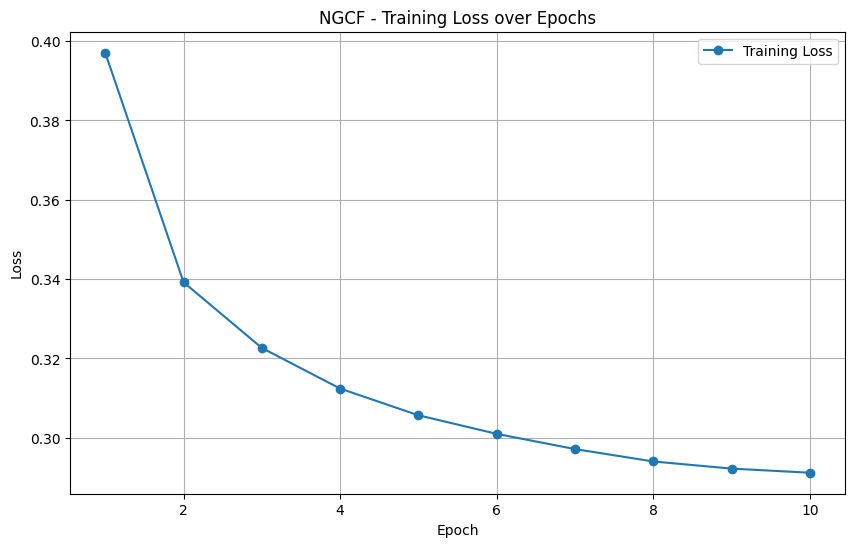


Evaluation on Test Data (k=20):
  Recall@20:    0.120041
  NDCG@20:      0.284297

Evaluation on Validation Data (k=20):
  Recall@20:    0.119878
  NDCG@20:      0.282213

User and item embeddings saved.


In [ ]:
import json
import numpy as np
import scipy.sparse as sp
import tensorflow as tf
import random
from tensorflow.keras.utils import Progbar
import math
import matplotlib.pyplot as plt
from collections import defaultdict

def load_mydataset(train_file, test_file, val_file):
    def read_json(path):
        with open(path, 'r') as f:
            data_list = json.load(f)
        return [set(x) for x in data_list]

    train_list = read_json(train_file)
    test_list  = read_json(test_file)
    val_list   = read_json(val_file)

    n_users = len(train_list)
    all_items = set()
    for user_items in train_list:
        all_items.update(user_items)
    for user_items in test_list:
        all_items.update(user_items)
    for user_items in val_list:
        all_items.update(user_items)

    n_items = max(all_items) + 1 if all_items else 0

    train_data = [set(u) for u in train_list]
    test_data  = [set(u) for u in test_list]
    val_data   = [set(u) for u in val_list]

    return train_data, test_data, val_data, n_users, n_items

def build_adjacency_matrix(train_data, n_users, n_items):
    """
    Build (n_users + n_items) x (n_users + n_items) adjacency:
       [0     R
        R^T   0 ]
    """
    R_dok = sp.dok_matrix((n_users, n_items), dtype=np.float32)
    for u, items in enumerate(train_data):
        for i in items:
            R_dok[u, i] = 1.0
    R_csr = R_dok.tocsr()

    adj_size = n_users + n_items
    adj_dok = sp.dok_matrix((adj_size, adj_size), dtype=np.float32)
    adj_dok[:n_users, n_users:] = R_csr
    adj_dok[n_users:, :n_users] = R_csr.transpose()
    return adj_dok.tocsr()

def normalize_adj_sym(adj_mat):
    """
    Symmetric Laplacian normalization with identity: (L + I) = D^-1/2 * A * D^-1/2 + I
    """
    # D^-1/2 * A * D^-1/2 (normalized Laplacian L)
    rowsum = np.array(adj_mat.sum(axis=1)).flatten() + 1e-9  # avoid division by zero
    d_inv_sqrt = np.power(rowsum, -0.5)
    d_inv_sqrt[np.isinf(d_inv_sqrt)] = 0.  # handle infinite values
    D_inv_sqrt = sp.diags(d_inv_sqrt)

    # normalized Laplacian: L = D^-1/2 * A * D^-1/2
    normalized_laplacian = D_inv_sqrt.dot(adj_mat).dot(D_inv_sqrt)

    # identity matrix: (L + I)
    identity = sp.eye(adj_mat.shape[0])
    return normalized_laplacian + identity


class NGCFModel(tf.keras.Model):
    def __init__(self, n_users, n_items, n_layers=3, emb_dim=64, decay=1e-4, adj_mat=None):
        super().__init__()
        self.n_users = n_users
        self.n_items = n_items
        self.n_layers = n_layers
        self.emb_dim = emb_dim
        self.decay = decay
        self.adj_mat = adj_mat

        initializer = tf.initializers.GlorotUniform()

        # user and item embeddings
        self.user_embedding = self.add_weight(
            name='user_embedding',
            shape=(n_users, emb_dim),
            initializer=initializer,
            trainable=True
        )
        self.item_embedding = self.add_weight(
            name='item_embedding',
            shape=(n_items, emb_dim),
            initializer=initializer,
            trainable=True
        )

        # layer-specific transformation weights (W1 and W2 per layer)
        self.W1 = [
            self.add_weight(
                name=f'W1_layer_{i}',
                shape=(emb_dim, emb_dim),
                initializer=initializer,
                trainable=True
            )
            for i in range(n_layers)
        ]
        self.W2 = [
            self.add_weight(
                name=f'W2_layer_{i}',
                shape=(emb_dim, emb_dim),
                initializer=initializer,
                trainable=True
            )
            for i in range(n_layers)
        ]

    def call(self, user_emb, item_emb, training=False, message_dropout_rate=0.1, node_dropout_rate=0.1):
        all_emb = tf.concat([user_emb, item_emb], axis=0)  # (n_users+n_items, emb_dim)
        emb_list = [all_emb]

        for layer in range(self.n_layers):
            # neighbor_emb: A * all_emb
            neighbor_emb = tf.sparse.sparse_dense_matmul(self.adj_mat, all_emb)

            # message dropout
            if training:
                neighbor_emb = tf.nn.dropout(neighbor_emb, rate=message_dropout_rate)

            # element-wise interaction
            interaction_emb = neighbor_emb * all_emb

            # linear transformation with W1, W2
            out = tf.nn.leaky_relu(
                tf.matmul(neighbor_emb, self.W1[layer]) +
                tf.matmul(interaction_emb, self.W2[layer])
            )

            # node dropout
            if training:
                node_mask = tf.random.uniform([self.n_users + self.n_items]) > node_dropout_rate
                node_mask = tf.cast(node_mask, dtype=tf.float32)
                out = out * tf.expand_dims(node_mask, axis=-1)

            all_emb = out
            emb_list.append(all_emb)

        # concat embeddings from each layer
        final_emb = tf.concat(emb_list, axis=1)
        new_user_emb, new_item_emb = tf.split(final_emb, [self.n_users, self.n_items], axis=0)
        return new_user_emb, new_item_emb

    def recommend(self, user_ids, k=10):
        updated_user_emb, updated_item_emb = self(
            self.user_embedding, self.item_embedding, training=False
        )
        user_vecs = tf.gather(updated_user_emb, user_ids)  # (len(user_ids), emb_dim)

        all_recs = []
        for i, uid in enumerate(user_ids):
            u_vec = user_vecs[i:i+1]  # (1, emb_dim)
            scores = tf.matmul(u_vec, updated_item_emb, transpose_b=True)  # (1, n_items)
            scores_np = scores.numpy().flatten()
            idx_topk = np.argsort(scores_np)[::-1][:k]
            score_topk = scores_np[idx_topk]
            for item_id, sc in zip(idx_topk, score_topk):
                all_recs.append((int(uid), int(item_id), float(sc)))
        return all_recs

# negative sampling for BPR
def sample_neg(interacted_items, n_items):
    while True:
        neg = random.randint(0, n_items - 1)
        if neg not in interacted_items:
            return neg

def train_ngcf(model, train_data, n_users, n_items, batch_size=1024, epochs=20, lr=1e-4):
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=lr,
        decay_steps=500,
        decay_rate=0.95,
        staircase=True
    )
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

    train_interactions = []
    for u in range(n_users):
        for i in train_data[u]:
            train_interactions.append((u, i))

    steps_per_epoch = len(train_interactions) // batch_size + (len(train_interactions) % batch_size != 0)
    epoch_losses = []

    for epoch in range(1, epochs + 1):
        print(f"Epoch {epoch}/{epochs}")
        progbar = Progbar(steps_per_epoch)
        random.shuffle(train_interactions)

        start_idx = 0
        epoch_loss = 0
        for step in range(steps_per_epoch):
            end_idx = min(start_idx + batch_size, len(train_interactions))
            batch_slice = train_interactions[start_idx:end_idx]
            start_idx = end_idx

            users = []
            pos_items = []
            neg_items = []
            for (u, i) in batch_slice:
                users.append(u)
                pos_items.append(i)
                neg_items.append(sample_neg(train_data[u], n_items))

            users = np.array(users, dtype=np.int32)
            pos_items = np.array(pos_items, dtype=np.int32)
            neg_items = np.array(neg_items, dtype=np.int32)

            with tf.GradientTape() as tape:
                updated_user_emb, updated_item_emb = model(
                    model.user_embedding,
                    model.item_embedding,
                    training=True,
                    message_dropout_rate=0.0,
                    node_dropout_rate=0.0
                )

                u_emb_batch = tf.nn.embedding_lookup(updated_user_emb, users)
                pos_emb_batch = tf.nn.embedding_lookup(updated_item_emb, pos_items)
                neg_emb_batch = tf.nn.embedding_lookup(updated_item_emb, neg_items)

                pos_scores = tf.reduce_sum(u_emb_batch * pos_emb_batch, axis=1)
                neg_scores = tf.reduce_sum(u_emb_batch * neg_emb_batch, axis=1)
                bpr_loss = tf.reduce_mean(tf.nn.softplus(neg_scores - pos_scores))
                # bpr_loss = -tf.reduce_mean(tf.math.log_sigmoid(pos_scores - neg_scores))
                reg_loss = model.decay * (
                    tf.nn.l2_loss(u_emb_batch) +
                    tf.nn.l2_loss(pos_emb_batch) +
                    tf.nn.l2_loss(neg_emb_batch)
                )
                loss = bpr_loss + reg_loss

            grads = tape.gradient(loss, model.trainable_variables)
            clipped_grads = [tf.clip_by_norm(g, 5.0) for g in grads]
            optimizer.apply_gradients(zip(clipped_grads, model.trainable_variables))

            epoch_loss += loss.numpy()
            progbar.add(1, values=[('loss', float(loss))])

        avg_epoch_loss = epoch_loss / steps_per_epoch
        epoch_losses.append(avg_epoch_loss)
        print(f"Epoch {epoch} Loss: {avg_epoch_loss:.6f}")

    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(epoch_losses) + 1), epoch_losses, marker='o', label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('NGCF - Training Loss over Epochs')
    plt.legend()
    plt.grid()
    plt.show()

    return epoch_losses

def recall_at_k(recs, test_data, k=10):
    user_recs = defaultdict(list)
    for (u, i, s) in recs:
        user_recs[u].append(i)
    recalls = []
    for u, items_pred in user_recs.items():
        gt = test_data[u]
        if len(gt) == 0:
            continue
        items_pred = items_pred[:k]
        num_hit = len(set(items_pred).intersection(gt))
        recalls.append(num_hit / float(len(gt)))
    return np.mean(recalls) if recalls else 0.0

def dcg_at_k(r, k):
    r = np.asfarray(r)[:k]
    if r.size:
        return np.sum(r / np.log2(np.arange(2, r.size + 2)))
    return 0.

def ndcg_at_k(recommended, ground_truth, k=10):
    rel = [1 if i in ground_truth else 0 for i in recommended[:k]]
    ideal_rel = sorted(rel, reverse=True)
    dcg = dcg_at_k(rel, k)
    idcg = dcg_at_k(ideal_rel, k)
    return (dcg / idcg) if idcg > 0 else 0.0

def ndcg(recs, test_data, k=10):
    user_recs = defaultdict(list)
    for (u, i, s) in recs:
        user_recs[u].append(i)
    ndcgs = []
    for u, items_pred in user_recs.items():
        gt = test_data[u]
        if len(gt) == 0:
            continue
        ndcgs.append(ndcg_at_k(items_pred, gt, k))
    return np.mean(ndcgs) if ndcgs else 0.0

train_file = '/kaggle/input/dataset-movielens/train_data.json'
test_file = '/kaggle/input/dataset-movielens/test_data.json'
val_file = '/kaggle/input/dataset-movielens/validation_data.json'

train_data, test_data, val_data, n_users, n_items = load_mydataset(
    train_file, test_file, val_file
)
print(f"Number of Users: {n_users}, Number of Items: {n_items}")

adj_csr = build_adjacency_matrix(train_data, n_users, n_items)
norm_adj_csr = normalize_adj_sym(adj_csr)

# convert to TF SparseTensor
coo = norm_adj_csr.tocoo().astype(np.float32)
indices = np.vstack((coo.row, coo.col)).transpose()
A_tilde = tf.sparse.SparseTensor(indices=indices, values=coo.data, dense_shape=coo.shape)
A_tilde = tf.sparse.reorder(A_tilde)

N_LAYERS = 3
EMBED_DIM = 64
DECAY = 1e-5
model = NGCFModel(
    n_users=n_users,
    n_items=n_items,
    n_layers=N_LAYERS,
    emb_dim=EMBED_DIM,
    decay=DECAY,
    adj_mat=A_tilde
)

EPOCHS = 10
BATCH_SIZE = 512
LR = 5e-4
epoch_losses = train_ngcf(
    model=model,
    train_data=train_data,
    n_users=n_users,
    n_items=n_items,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    lr=LR
)

K = 20
test_users = [u for u in range(n_users) if len(test_data[u]) > 0]
all_recs = []
batch_u = 2000
start = 0
while start < len(test_users):
    end = min(start + batch_u, len(test_users))
    user_batch = test_users[start:end]
    recs_chunk = model.recommend(user_batch, k=K)
    all_recs.extend(recs_chunk)
    start = end

recall_10 = recall_at_k(all_recs, test_data, k=K)
ndcg_10   = ndcg(all_recs, test_data, k=K)

print(f"\nEvaluation on Test Data (k={K}):")
print(f"  Recall@{K}:    {recall_10:.6f}")
print(f"  NDCG@{K}:      {ndcg_10:.6f}")

val_users = [u for u in range(n_users) if len(val_data[u]) > 0]
val_recs = []
start = 0
while start < len(val_users):
    end = min(start + batch_u, len(val_users))
    user_batch = val_users[start:end]
    recs_chunk = model.recommend(user_batch, k=K)
    val_recs.extend(recs_chunk)
    start = end

recall_val = recall_at_k(val_recs, val_data, k=K)
ndcg_val   = ndcg(val_recs, val_data, k=K)

print(f"\nEvaluation on Validation Data (k={K}):")
print(f"  Recall@{K}:    {recall_val:.6f}")
print(f"  NDCG@{K}:      {ndcg_val:.6f}")

updated_user_emb, updated_item_emb = model(
    model.user_embedding, model.item_embedding, training=False
)
np.save("ngcf_user_embeddings.npy", updated_user_emb.numpy())
np.save("ngcf_item_embeddings.npy", updated_item_emb.numpy())
print("\nUser and item embeddings saved.") 

# Hyperparameter Tuning

In [ ]:
from itertools import product

def hyperparameter_tuning_ngcf(train_data, val_data, n_users, n_items, adj_mat, param_grid, patience=5, max_epochs=50, k=20):
    best_params = None
    best_metrics = {"ndcg": 0.0, "recall": 0.0}
    best_epoch = 0

    # iterate through all parameter combinations
    param_combinations = list(product(*param_grid.values()))
    for params in param_combinations:
        n_layers, emb_dim, decay, lr, batch_size = params
        print(f"\nTrying parameters: Layers={n_layers}, Embedding={emb_dim}, Decay={decay}, LR={lr}, Batch Size={batch_size}")

        model = NGCFModel(
            n_users=n_users,
            n_items=n_items,
            n_layers=n_layers,
            emb_dim=emb_dim,
            decay=decay,
            adj_mat=adj_mat
        )

        lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=lr,
            decay_steps=500,
            decay_rate=0.95,
            staircase=True
        )
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

        train_interactions = [(u, i) for u in range(n_users) for i in train_data[u]]
        steps_per_epoch = len(train_interactions) // batch_size + (len(train_interactions) % batch_size != 0)
        no_improvement_epochs = 0
        best_val_ndcg = 0.0
        best_val_recall = 0.0

        for epoch in range(1, max_epochs + 1):
            random.shuffle(train_interactions)
            epoch_loss = 0

            # training loop per batch
            for step in range(steps_per_epoch):
                batch_interactions = train_interactions[step * batch_size:(step + 1) * batch_size]
                users, pos_items, neg_items = zip(*[
                    (u, i, sample_neg(train_data[u], n_items)) for u, i in batch_interactions
                ])

                users = np.array(users, dtype=np.int32)
                pos_items = np.array(pos_items, dtype=np.int32)
                neg_items = np.array(neg_items, dtype=np.int32)

                with tf.GradientTape() as tape:
                    user_emb, item_emb = model(
                        model.user_embedding,
                        model.item_embedding,
                        training=True,
                        message_dropout_rate=0.1,
                        node_dropout_rate=0.1
                    )
                    u_emb = tf.nn.embedding_lookup(user_emb, users)
                    pos_emb = tf.nn.embedding_lookup(item_emb, pos_items)
                    neg_emb = tf.nn.embedding_lookup(item_emb, neg_items)

                    pos_scores = tf.reduce_sum(u_emb * pos_emb, axis=1)
                    neg_scores = tf.reduce_sum(u_emb * neg_emb, axis=1)
                    bpr_loss = tf.reduce_mean(tf.nn.softplus(neg_scores - pos_scores))

                    reg_loss = model.decay * (tf.nn.l2_loss(u_emb) + tf.nn.l2_loss(pos_emb) + tf.nn.l2_loss(neg_emb))
                    loss = bpr_loss + reg_loss

                grads = tape.gradient(loss, model.trainable_variables)
                optimizer.apply_gradients(zip(grads, model.trainable_variables))
                epoch_loss += loss.numpy()

            print(f"Epoch {epoch}/{max_epochs}")

            # validation evaluation
            val_users = [u for u in range(n_users) if len(val_data[u]) > 0]
            val_recs = []
            for i in range(0, len(val_users), 2000):
                user_batch = val_users[i:i + 2000]
                val_recs.extend(model.recommend(user_batch, k=k))

            val_ndcg = ndcg(val_recs, val_data, k=k)
            val_recall = recall_at_k(val_recs, val_data, k=k)
            print(f"Validation NDCG@{k}: {val_ndcg:.6f}, Recall@{k}: {val_recall:.6f}")

            if val_ndcg > best_val_ndcg or val_recall > best_val_recall:
                best_val_ndcg = max(val_ndcg, best_val_ndcg)
                best_val_recall = max(val_recall, best_val_recall)
                no_improvement_epochs = 0
                best_model_params = model.get_weights()
                best_epoch = epoch
            else:
                no_improvement_epochs += 1

            if no_improvement_epochs >= patience:
                print(f"Early stopping at epoch {epoch}. Best NDCG@{k}: {best_val_ndcg:.6f}, Recall@{k}: {best_val_recall:.6f}")
                break

        # update best parameters if this combination performs better
        if best_val_ndcg > best_metrics["ndcg"] or best_val_recall > best_metrics["recall"]:
            best_params = params
            best_metrics = {"ndcg": best_val_ndcg, "recall": best_val_recall}

    print(f"\nBest Parameters: Layers={best_params[0]}, Embedding={best_params[1]}, Decay={best_params[2]}, LR={best_params[3]}, Batch Size={best_params[4]}")
    print(f"Best Validation Metrics: NDCG@{k}={best_metrics['ndcg']:.6f}, Recall@{k}={best_metrics['recall']:.6f}")
    return best_params, best_metrics

# Define parameter grid
param_grid = {
    "n_layers": [2, 3, 4],
    "emb_dim": [32, 64, 128],
    "decay": [1e-4, 1e-5, 1e-6],
    "lr": [1e-4, 5e-4, 1e-3],
    "batch_size": [1024]
}

best_params, best_metrics = hyperparameter_tuning_ngcf(
    train_data=train_data,
    val_data=val_data,
    n_users=n_users,
    n_items=n_items,
    adj_mat=A_tilde,
    param_grid=param_grid,
    patience=5,
    max_epochs=5,
    k=20
)



Trying parameters: Layers=2, Embedding=32, Decay=0.0001, LR=0.0001, Batch Size=1024
Epoch 1/5
Validation NDCG@20: 0.098452, Recall@20: 0.018515
Epoch 2/5
Validation NDCG@20: 0.131650, Recall@20: 0.029259
Epoch 3/5
Validation NDCG@20: 0.151314, Recall@20: 0.037683
Epoch 4/5
Validation NDCG@20: 0.161357, Recall@20: 0.042034
Epoch 5/5
Validation NDCG@20: 0.172440, Recall@20: 0.047737

Trying parameters: Layers=2, Embedding=32, Decay=0.0001, LR=0.0005, Batch Size=1024
Epoch 1/5
Validation NDCG@20: 0.146718, Recall@20: 0.038646
Epoch 2/5
Validation NDCG@20: 0.180652, Recall@20: 0.055619
Epoch 3/5
Validation NDCG@20: 0.191617, Recall@20: 0.061770
Epoch 4/5
Validation NDCG@20: 0.194117, Recall@20: 0.064065
Epoch 5/5
Validation NDCG@20: 0.198874, Recall@20: 0.066784

Trying parameters: Layers=2, Embedding=32, Decay=0.0001, LR=0.001, Batch Size=1024
Epoch 1/5
Validation NDCG@20: 0.168078, Recall@20: 0.044447
Epoch 2/5
Validation NDCG@20: 0.188116, Recall@20: 0.056724
Epoch 3/5
Validation NDCG@

In [ ]:
from itertools import product

def hyperparameter_tuning_ngcf(train_data, val_data, n_users, n_items, adj_mat, param_grid, patience=5, max_epochs=50, k=20):
    best_params = None
    best_metrics = {"ndcg": 0.0, "recall": 0.0}
    best_epoch = 0

    param_combinations = list(product(*param_grid.values()))
    for params in param_combinations:
        n_layers, emb_dim, decay, lr, batch_size = params
        print(f"\nTrying parameters: Layers={n_layers}, Embedding={emb_dim}, Decay={decay}, LR={lr}, Batch Size={batch_size}")

        model = NGCFModel(
            n_users=n_users,
            n_items=n_items,
            n_layers=n_layers,
            emb_dim=emb_dim,
            decay=decay,
            adj_mat=adj_mat
        )

        lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=lr,
            decay_steps=500,
            decay_rate=0.95,
            staircase=True
        )
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

        train_interactions = [(u, i) for u in range(n_users) for i in train_data[u]]
        steps_per_epoch = len(train_interactions) // batch_size + (len(train_interactions) % batch_size != 0)
        no_improvement_epochs = 0
        best_val_ndcg = 0.0
        best_val_recall = 0.0

        for epoch in range(1, max_epochs + 1):
            random.shuffle(train_interactions)
            epoch_loss = 0

            # training loop per batch
            for step in range(steps_per_epoch):
                batch_interactions = train_interactions[step * batch_size:(step + 1) * batch_size]
                users, pos_items, neg_items = zip(*[
                    (u, i, sample_neg(train_data[u], n_items)) for u, i in batch_interactions
                ])

                users = np.array(users, dtype=np.int32)
                pos_items = np.array(pos_items, dtype=np.int32)
                neg_items = np.array(neg_items, dtype=np.int32)

                with tf.GradientTape() as tape:
                    user_emb, item_emb = model(
                        model.user_embedding,
                        model.item_embedding,
                        training=True,
                        message_dropout_rate=0.1,
                        node_dropout_rate=0.1
                    )
                    u_emb = tf.nn.embedding_lookup(user_emb, users)
                    pos_emb = tf.nn.embedding_lookup(item_emb, pos_items)
                    neg_emb = tf.nn.embedding_lookup(item_emb, neg_items)

                    pos_scores = tf.reduce_sum(u_emb * pos_emb, axis=1)
                    neg_scores = tf.reduce_sum(u_emb * neg_emb, axis=1)
                    bpr_loss = tf.reduce_mean(tf.nn.softplus(neg_scores - pos_scores))

                    reg_loss = model.decay * (tf.nn.l2_loss(u_emb) + tf.nn.l2_loss(pos_emb) + tf.nn.l2_loss(neg_emb))
                    loss = bpr_loss + reg_loss

                grads = tape.gradient(loss, model.trainable_variables)
                optimizer.apply_gradients(zip(grads, model.trainable_variables))
                epoch_loss += loss.numpy()

            print(f"Epoch {epoch}/{max_epochs}")

            # validation evaluation
            val_users = [u for u in range(n_users) if len(val_data[u]) > 0]
            val_recs = []
            for i in range(0, len(val_users), 2000):
                user_batch = val_users[i:i + 2000]
                val_recs.extend(model.recommend(user_batch, k=k))

            val_ndcg = ndcg(val_recs, val_data, k=k)
            val_recall = recall_at_k(val_recs, val_data, k=k)
            print(f"Validation NDCG@{k}: {val_ndcg:.6f}, Recall@{k}: {val_recall:.6f}")

            if val_ndcg > best_val_ndcg or val_recall > best_val_recall:
                best_val_ndcg = max(val_ndcg, best_val_ndcg)
                best_val_recall = max(val_recall, best_val_recall)
                no_improvement_epochs = 0
                best_model_params = model.get_weights()
                best_epoch = epoch
            else:
                no_improvement_epochs += 1

            if no_improvement_epochs >= patience:
                print(f"Early stopping at epoch {epoch}. Best NDCG@{k}: {best_val_ndcg:.6f}, Recall@{k}: {best_val_recall:.6f}")
                break

        if best_val_ndcg > best_metrics["ndcg"] or best_val_recall > best_metrics["recall"]:
            best_params = params
            best_metrics = {"ndcg": best_val_ndcg, "recall": best_val_recall}

    print(f"\nBest Parameters: Layers={best_params[0]}, Embedding={best_params[1]}, Decay={best_params[2]}, LR={best_params[3]}, Batch Size={best_params[4]}")
    print(f"Best Validation Metrics: NDCG@{k}={best_metrics['ndcg']:.6f}, Recall@{k}={best_metrics['recall']:.6f}")
    return best_params, best_metrics

param_grid = {
    "n_layers": [3, 4],
    "emb_dim": [64, 128],
    "decay": [1e-4, 1e-5, 1e-6],
    "lr": [1e-4, 5e-4, 1e-3],
    "batch_size": [1024]
}

train_file = '/kaggle/input/dataset-movielens/train_data.json'
test_file = '/kaggle/input/dataset-movielens/test_data.json'
val_file = '/kaggle/input/dataset-movielens/validation_data.json'

train_data, test_data, val_data, n_users, n_items = load_mydataset(
    train_file, test_file, val_file
)

adj_csr = build_adjacency_matrix(train_data, n_users, n_items)
norm_adj_csr = normalize_adj_sym(adj_csr)

coo = norm_adj_csr.tocoo().astype(np.float32)
indices = np.vstack((coo.row, coo.col)).transpose()
A_tilde = tf.sparse.SparseTensor(indices=indices, values=coo.data, dense_shape=coo.shape)
A_tilde = tf.sparse.reorder(A_tilde)

best_params, best_metrics = hyperparameter_tuning_ngcf(
    train_data=train_data,
    val_data=val_data,
    n_users=n_users,
    n_items=n_items,
    adj_mat=A_tilde,
    param_grid=param_grid,
    patience=5,
    max_epochs=5,
    k=20
)



Trying parameters: Layers=3, Embedding=64, Decay=0.0001, LR=0.0001, Batch Size=1024
Epoch 1/5
Validation NDCG@20: 0.016584, Recall@20: 0.002410
Epoch 2/5
Validation NDCG@20: 0.220346, Recall@20: 0.078384
Epoch 3/5
Validation NDCG@20: 0.218643, Recall@20: 0.076313
Epoch 4/5
Validation NDCG@20: 0.218797, Recall@20: 0.078266
Epoch 5/5
Validation NDCG@20: 0.216680, Recall@20: 0.078144

Trying parameters: Layers=3, Embedding=64, Decay=0.0001, LR=0.0005, Batch Size=1024
Epoch 1/5
Validation NDCG@20: 0.220932, Recall@20: 0.077905
Epoch 2/5
Validation NDCG@20: 0.221586, Recall@20: 0.079101
Epoch 3/5
Validation NDCG@20: 0.222593, Recall@20: 0.078854
Epoch 4/5
Validation NDCG@20: 0.219354, Recall@20: 0.077729
Epoch 5/5
Validation NDCG@20: 0.222815, Recall@20: 0.079135

Trying parameters: Layers=3, Embedding=64, Decay=0.0001, LR=0.001, Batch Size=1024
Epoch 1/5
Validation NDCG@20: 0.220774, Recall@20: 0.079181
Epoch 2/5
Validation NDCG@20: 0.222435, Recall@20: 0.078954
Epoch 3/5
Validation NDCG@

Number of Users: 6022, Number of Items: 3043
Epoch 1/10
778/778 ━━━━━━━━━━━━━━━━━━━━ 103s 132ms/step - loss: 0.4110
Epoch 1 Loss: 0.411035
Epoch 2/10
778/778 ━━━━━━━━━━━━━━━━━━━━ 103s 132ms/step - loss: 0.3112
Epoch 2 Loss: 0.311220
Epoch 3/10
778/778 ━━━━━━━━━━━━━━━━━━━━ 103s 132ms/step - loss: 0.2848
Epoch 3 Loss: 0.284818
Epoch 4/10
778/778 ━━━━━━━━━━━━━━━━━━━━ 103s 131ms/step - loss: 0.2682
Epoch 4 Loss: 0.268183
Epoch 5/10
778/778 ━━━━━━━━━━━━━━━━━━━━ 103s 132ms/step - loss: 0.2559
Epoch 5 Loss: 0.255867
Epoch 6/10
778/778 ━━━━━━━━━━━━━━━━━━━━ 103s 131ms/step - loss: 0.2464
Epoch 6 Loss: 0.246410
Epoch 7/10
778/778 ━━━━━━━━━━━━━━━━━━━━ 103s 132ms/step - loss: 0.2369
Epoch 7 Loss: 0.236856
Epoch 8/10
778/778 ━━━━━━━━━━━━━━━━━━━━ 106s 135ms/step - loss: 0.2296
Epoch 8 Loss: 0.229636
Epoch 9/10
778/778 ━━━━━━━━━━━━━━━━━━━━ 105s 134ms/step - loss: 0.2238
Epoch 9 Loss: 0.223816
Epoch 10/10
778/778 ━━━━━━━━━━━━━━━━━━━━ 102s 131ms/step - loss: 0.2185
Epoch 10 Loss: 0.218516


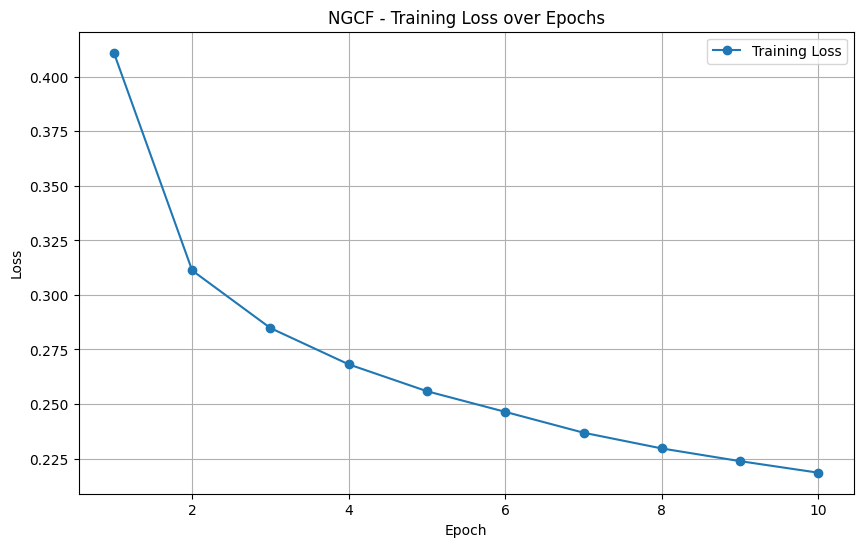


Evaluation on Test Data (k=20):
  Recall@20:    0.136998
  NDCG@20:      0.289316

Evaluation on Validation Data (k=20):
  Recall@20:    0.134252
  NDCG@20:      0.291581

User and item embeddings saved.


In [ ]:
import json
import numpy as np
import scipy.sparse as sp
import tensorflow as tf
import random
from tensorflow.keras.utils import Progbar
import math
import matplotlib.pyplot as plt
from collections import defaultdict

def load_mydataset(train_file, test_file, val_file):
    def read_json(path):
        with open(path, 'r') as f:
            data_list = json.load(f)
        return [set(x) for x in data_list]

    train_list = read_json(train_file)
    test_list  = read_json(test_file)
    val_list   = read_json(val_file)

    n_users = len(train_list)
    all_items = set()
    for user_items in train_list:
        all_items.update(user_items)
    for user_items in test_list:
        all_items.update(user_items)
    for user_items in val_list:
        all_items.update(user_items)

    n_items = max(all_items) + 1 if all_items else 0

    train_data = [set(u) for u in train_list]
    test_data  = [set(u) for u in test_list]
    val_data   = [set(u) for u in val_list]

    return train_data, test_data, val_data, n_users, n_items

def build_adjacency_matrix(train_data, n_users, n_items):
    """
    Build (n_users + n_items) x (n_users + n_items) adjacency:
       [0     R
        R^T   0 ]
    """
    R_dok = sp.dok_matrix((n_users, n_items), dtype=np.float32)
    for u, items in enumerate(train_data):
        for i in items:
            R_dok[u, i] = 1.0
    R_csr = R_dok.tocsr()

    adj_size = n_users + n_items
    adj_dok = sp.dok_matrix((adj_size, adj_size), dtype=np.float32)
    adj_dok[:n_users, n_users:] = R_csr
    adj_dok[n_users:, :n_users] = R_csr.transpose()
    return adj_dok.tocsr()

def normalize_adj_sym(adj_mat):
    """
    Symmetric Laplacian normalization with identity: (L + I) = D^-1/2 * A * D^-1/2 + I
    """
    # D^-1/2 * A * D^-1/2 (normalized Laplacian L)
    rowsum = np.array(adj_mat.sum(axis=1)).flatten() + 1e-9  # avoid division by zero
    d_inv_sqrt = np.power(rowsum, -0.5)
    d_inv_sqrt[np.isinf(d_inv_sqrt)] = 0.  # handle infinite values
    D_inv_sqrt = sp.diags(d_inv_sqrt)

    # normalized Laplacian: L = D^-1/2 * A * D^-1/2
    normalized_laplacian = D_inv_sqrt.dot(adj_mat).dot(D_inv_sqrt)

    # identity matrix: (L + I)
    identity = sp.eye(adj_mat.shape[0])
    return normalized_laplacian + identity

class NGCFModel(tf.keras.Model):
    def __init__(self, n_users, n_items, n_layers=3, emb_dim=64, decay=1e-4, adj_mat=None):
        super().__init__()
        self.n_users = n_users
        self.n_items = n_items
        self.n_layers = n_layers
        self.emb_dim = emb_dim
        self.decay = decay
        self.adj_mat = adj_mat  # TF SparseTensor

        initializer = tf.initializers.GlorotUniform()

        self.user_embedding = self.add_weight(
            name='user_embedding',
            shape=(n_users, emb_dim),
            initializer=initializer,
            trainable=True
        )
        self.item_embedding = self.add_weight(
            name='item_embedding',
            shape=(n_items, emb_dim),
            initializer=initializer,
            trainable=True
        )

        # layer-specific transformation weights (W1 and W2 per layer)
        self.W1 = [
            self.add_weight(
                name=f'W1_layer_{i}',
                shape=(emb_dim, emb_dim),
                initializer=initializer,
                trainable=True
            )
            for i in range(n_layers)
        ]
        self.W2 = [
            self.add_weight(
                name=f'W2_layer_{i}',
                shape=(emb_dim, emb_dim),
                initializer=initializer,
                trainable=True
            )
            for i in range(n_layers)
        ]

    def call(self, user_emb, item_emb, training=False, message_dropout_rate=0.1, node_dropout_rate=0.1):
        all_emb = tf.concat([user_emb, item_emb], axis=0)  # shape (n_users+n_items, emb_dim)
        emb_list = [all_emb]

        for layer in range(self.n_layers):
            # neighbor_emb: A * all_emb
            neighbor_emb = tf.sparse.sparse_dense_matmul(self.adj_mat, all_emb)

            if training:
                neighbor_emb = tf.nn.dropout(neighbor_emb, rate=message_dropout_rate)

            # element-wise interaction
            interaction_emb = neighbor_emb * all_emb

            # linear transformation with W1, W2
            out = tf.nn.leaky_relu(
                tf.matmul(neighbor_emb, self.W1[layer]) +
                tf.matmul(interaction_emb, self.W2[layer])
            )

            # node dropout
            if training:
                node_mask = tf.random.uniform([self.n_users + self.n_items]) > node_dropout_rate
                node_mask = tf.cast(node_mask, dtype=tf.float32)
                out = out * tf.expand_dims(node_mask, axis=-1)

            all_emb = out
            emb_list.append(all_emb)

        # concat embeddings from each layer
        final_emb = tf.concat(emb_list, axis=1)
        new_user_emb, new_item_emb = tf.split(final_emb, [self.n_users, self.n_items], axis=0)
        return new_user_emb, new_item_emb

    def recommend(self, user_ids, k=10):
        updated_user_emb, updated_item_emb = self(
            self.user_embedding, self.item_embedding, training=False
        )
        user_vecs = tf.gather(updated_user_emb, user_ids)  # (len(user_ids), emb_dim)

        all_recs = []
        for i, uid in enumerate(user_ids):
            u_vec = user_vecs[i:i+1]  # (1, emb_dim)
            scores = tf.matmul(u_vec, updated_item_emb, transpose_b=True)  # (1, n_items)
            scores_np = scores.numpy().flatten()
            idx_topk = np.argsort(scores_np)[::-1][:k]
            score_topk = scores_np[idx_topk]
            for item_id, sc in zip(idx_topk, score_topk):
                all_recs.append((int(uid), int(item_id), float(sc)))
        return all_recs


# negative Sampling for BPR
def sample_neg(interacted_items, n_items):
    while True:
        neg = random.randint(0, n_items - 1)
        if neg not in interacted_items:
            return neg

def train_ngcf(model, train_data, n_users, n_items, batch_size=1024, epochs=20, lr=1e-4):
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=lr,
        decay_steps=500,
        decay_rate=0.95,
        staircase=True
    )
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

    train_interactions = []
    for u in range(n_users):
        for i in train_data[u]:
            train_interactions.append((u, i))

    steps_per_epoch = len(train_interactions) // batch_size + (len(train_interactions) % batch_size != 0)
    epoch_losses = []

    for epoch in range(1, epochs + 1):
        print(f"Epoch {epoch}/{epochs}")
        progbar = Progbar(steps_per_epoch)
        random.shuffle(train_interactions)

        start_idx = 0
        epoch_loss = 0
        for step in range(steps_per_epoch):
            end_idx = min(start_idx + batch_size, len(train_interactions))
            batch_slice = train_interactions[start_idx:end_idx]
            start_idx = end_idx

            users = []
            pos_items = []
            neg_items = []
            for (u, i) in batch_slice:
                users.append(u)
                pos_items.append(i)
                neg_items.append(sample_neg(train_data[u], n_items))

            users = np.array(users, dtype=np.int32)
            pos_items = np.array(pos_items, dtype=np.int32)
            neg_items = np.array(neg_items, dtype=np.int32)

            with tf.GradientTape() as tape:
                updated_user_emb, updated_item_emb = model(
                    model.user_embedding,
                    model.item_embedding,
                    training=True,
                    message_dropout_rate=0.0,
                    node_dropout_rate=0.0
                )

                u_emb_batch = tf.nn.embedding_lookup(updated_user_emb, users)
                pos_emb_batch = tf.nn.embedding_lookup(updated_item_emb, pos_items)
                neg_emb_batch = tf.nn.embedding_lookup(updated_item_emb, neg_items)

                pos_scores = tf.reduce_sum(u_emb_batch * pos_emb_batch, axis=1)
                neg_scores = tf.reduce_sum(u_emb_batch * neg_emb_batch, axis=1)
                bpr_loss = tf.reduce_mean(tf.nn.softplus(neg_scores - pos_scores))
                # bpr_loss = -tf.reduce_mean(tf.math.log_sigmoid(pos_scores - neg_scores))
                
                reg_loss = model.decay * (
                    tf.nn.l2_loss(u_emb_batch) +
                    tf.nn.l2_loss(pos_emb_batch) +
                    tf.nn.l2_loss(neg_emb_batch)
                )
                loss = bpr_loss + reg_loss

            grads = tape.gradient(loss, model.trainable_variables)
            clipped_grads = [tf.clip_by_norm(g, 5.0) for g in grads]
            optimizer.apply_gradients(zip(clipped_grads, model.trainable_variables))

            epoch_loss += loss.numpy()
            progbar.add(1, values=[('loss', float(loss))])

        avg_epoch_loss = epoch_loss / steps_per_epoch
        epoch_losses.append(avg_epoch_loss)
        print(f"Epoch {epoch} Loss: {avg_epoch_loss:.6f}")

    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(epoch_losses) + 1), epoch_losses, marker='o', label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('NGCF - Training Loss over Epochs')
    plt.legend()
    plt.grid()
    plt.show()

    return epoch_losses

def recall_at_k(recs, test_data, k=10):
    user_recs = defaultdict(list)
    for (u, i, s) in recs:
        user_recs[u].append(i)
    recalls = []
    for u, items_pred in user_recs.items():
        gt = test_data[u]
        if len(gt) == 0:
            continue
        items_pred = items_pred[:k]
        num_hit = len(set(items_pred).intersection(gt))
        recalls.append(num_hit / float(len(gt)))
    return np.mean(recalls) if recalls else 0.0

def dcg_at_k(r, k):
    r = np.asfarray(r)[:k]
    if r.size:
        return np.sum(r / np.log2(np.arange(2, r.size + 2)))
    return 0.

def ndcg_at_k(recommended, ground_truth, k=10):
    rel = [1 if i in ground_truth else 0 for i in recommended[:k]]
    ideal_rel = sorted(rel, reverse=True)
    dcg = dcg_at_k(rel, k)
    idcg = dcg_at_k(ideal_rel, k)
    return (dcg / idcg) if idcg > 0 else 0.0

def ndcg(recs, test_data, k=10):
    user_recs = defaultdict(list)
    for (u, i, s) in recs:
        user_recs[u].append(i)
    ndcgs = []
    for u, items_pred in user_recs.items():
        gt = test_data[u]
        if len(gt) == 0:
            continue
        ndcgs.append(ndcg_at_k(items_pred, gt, k))
    return np.mean(ndcgs) if ndcgs else 0.0

train_file = '/kaggle/input/dataset-movielens/train_data.json'
test_file = '/kaggle/input/dataset-movielens/test_data.json'
val_file = '/kaggle/input/dataset-movielens/validation_data.json'

train_data, test_data, val_data, n_users, n_items = load_mydataset(
    train_file, test_file, val_file
)
print(f"Number of Users: {n_users}, Number of Items: {n_items}")

adj_csr = build_adjacency_matrix(train_data, n_users, n_items)
norm_adj_csr = normalize_adj_sym(adj_csr)

# convert to TF SparseTensor
coo = norm_adj_csr.tocoo().astype(np.float32)
indices = np.vstack((coo.row, coo.col)).transpose()
A_tilde = tf.sparse.SparseTensor(indices=indices, values=coo.data, dense_shape=coo.shape)
A_tilde = tf.sparse.reorder(A_tilde)

N_LAYERS = 3
EMBED_DIM = 128
DECAY = 1e-6
model = NGCFModel(
    n_users=n_users,
    n_items=n_items,
    n_layers=N_LAYERS,
    emb_dim=EMBED_DIM,
    decay=DECAY,
    adj_mat=A_tilde
)

EPOCHS = 10
BATCH_SIZE = 1024
LR = 1e-3
epoch_losses = train_ngcf(
    model=model,
    train_data=train_data,
    n_users=n_users,
    n_items=n_items,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    lr=LR
)

K = 20
test_users = [u for u in range(n_users) if len(test_data[u]) > 0]
all_recs = []
batch_u = 2000
start = 0
while start < len(test_users):
    end = min(start + batch_u, len(test_users))
    user_batch = test_users[start:end]
    recs_chunk = model.recommend(user_batch, k=K)
    all_recs.extend(recs_chunk)
    start = end

recall_20 = recall_at_k(all_recs, test_data, k=K)
ndcg_20   = ndcg(all_recs, test_data, k=K)

print(f"\nEvaluation on Test Data (k={K}):")
print(f"  Recall@{K}:    {recall_20:.6f}")
print(f"  NDCG@{K}:      {ndcg_20:.6f}")

# evaluate on validation data
val_users = [u for u in range(n_users) if len(val_data[u]) > 0]
val_recs = []
start = 0
while start < len(val_users):
    end = min(start + batch_u, len(val_users))
    user_batch = val_users[start:end]
    recs_chunk = model.recommend(user_batch, k=K)
    val_recs.extend(recs_chunk)
    start = end

recall_val = recall_at_k(val_recs, val_data, k=K)
ndcg_val   = ndcg(val_recs, val_data, k=K)

print(f"\nEvaluation on Validation Data (k={K}):")
print(f"  Recall@{K}:    {recall_val:.6f}")
print(f"  NDCG@{K}:      {ndcg_val:.6f}")

updated_user_emb, updated_item_emb = model(
    model.user_embedding, model.item_embedding, training=False
)
np.save("ngcf_user_embeddings.npy", updated_user_emb.numpy())
np.save("ngcf_item_embeddings.npy", updated_item_emb.numpy())
print("\nUser and item embeddings saved.") 

# Aggregation with LSTM

Number of Users: 6022, Number of Items: 3043
Epoch 1/10
778/778 ━━━━━━━━━━━━━━━━━━━━ 392s 501ms/step - loss: 0.4096
Epoch 1 Loss: 0.409609
Epoch 2/10
778/778 ━━━━━━━━━━━━━━━━━━━━ 390s 501ms/step - loss: 0.3593
Epoch 2 Loss: 0.359314
Epoch 3/10
778/778 ━━━━━━━━━━━━━━━━━━━━ 391s 501ms/step - loss: 0.3288
Epoch 3 Loss: 0.328818
Epoch 4/10
778/778 ━━━━━━━━━━━━━━━━━━━━ 391s 502ms/step - loss: 0.3077
Epoch 4 Loss: 0.307700
Epoch 5/10
778/778 ━━━━━━━━━━━━━━━━━━━━ 391s 501ms/step - loss: 0.2926
Epoch 5 Loss: 0.292575
Epoch 6/10
778/778 ━━━━━━━━━━━━━━━━━━━━ 390s 501ms/step - loss: 0.2841
Epoch 6 Loss: 0.284076
Epoch 7/10
778/778 ━━━━━━━━━━━━━━━━━━━━ 388s 498ms/step - loss: 0.2759
Epoch 7 Loss: 0.275870
Epoch 8/10
778/778 ━━━━━━━━━━━━━━━━━━━━ 390s 501ms/step - loss: 0.2700
Epoch 8 Loss: 0.270039
Epoch 9/10
778/778 ━━━━━━━━━━━━━━━━━━━━ 392s 503ms/step - loss: 0.2642
Epoch 9 Loss: 0.264248
Epoch 10/10
778/778 ━━━━━━━━━━━━━━━━━━━━ 390s 501ms/step - loss: 0.2612
Epoch 10 Loss: 0.261211


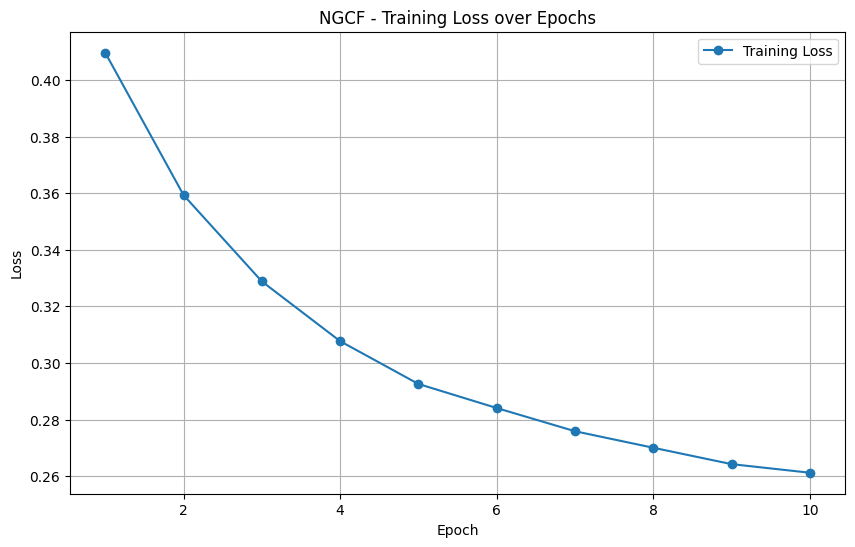


Evaluation on Test Data (k=20):
  Recall@20:    0.120710
  NDCG@20:      0.280290

User and item embeddings saved.


In [ ]:
import json
import numpy as np
import scipy.sparse as sp
import tensorflow as tf
import random
from tensorflow.keras.utils import Progbar
import math
import matplotlib.pyplot as plt
from collections import defaultdict

def load_mydataset(train_file, test_file, val_file):
    def read_json(path):
        with open(path, 'r') as f:
            data_list = json.load(f)
        return [set(x) for x in data_list]

    train_list = read_json(train_file)
    test_list  = read_json(test_file)
    val_list   = read_json(val_file)

    n_users = len(train_list)
    all_items = set()
    for user_items in train_list:
        all_items.update(user_items)
    for user_items in test_list:
        all_items.update(user_items)
    for user_items in val_list:
        all_items.update(user_items)

    n_items = max(all_items) + 1 if all_items else 0

    train_data = [set(u) for u in train_list]
    test_data  = [set(u) for u in test_list]
    val_data   = [set(u) for u in val_list]

    return train_data, test_data, val_data, n_users, n_items

def build_adjacency_matrix(train_data, n_users, n_items):
    """
    Build (n_users + n_items) x (n_users + n_items) adjacency:
       [0     R
        R^T   0 ]
    """
    R_dok = sp.dok_matrix((n_users, n_items), dtype=np.float32)
    for u, items in enumerate(train_data):
        for i in items:
            R_dok[u, i] = 1.0
    R_csr = R_dok.tocsr()

    adj_size = n_users + n_items
    adj_dok = sp.dok_matrix((adj_size, adj_size), dtype=np.float32)
    adj_dok[:n_users, n_users:] = R_csr
    adj_dok[n_users:, :n_users] = R_csr.transpose()
    return adj_dok.tocsr()

def normalize_adj_sym(adj_mat):
    """
    Symmetric Laplacian normalization with identity: (L + I) = D^-1/2 * A * D^-1/2 + I
    """
    # D^-1/2 * A * D^-1/2 (normalized Laplacian L)
    rowsum = np.array(adj_mat.sum(axis=1)).flatten() + 1e-9  # avoid division by zero
    d_inv_sqrt = np.power(rowsum, -0.5)
    d_inv_sqrt[np.isinf(d_inv_sqrt)] = 0.  # handle infinite values
    D_inv_sqrt = sp.diags(d_inv_sqrt)

    # normalized Laplacian: L = D^-1/2 * A * D^-1/2
    normalized_laplacian = D_inv_sqrt.dot(adj_mat).dot(D_inv_sqrt)

    # identity matrix: (L + I)
    identity = sp.eye(adj_mat.shape[0])
    return normalized_laplacian + identity

class NGCFModel(tf.keras.Model):
    def __init__(self, n_users, n_items, n_layers=3, emb_dim=64, decay=1e-4, adj_mat=None, max_neighbors=50):
        super().__init__()
        self.n_users = n_users
        self.n_items = n_items
        self.n_layers = n_layers
        self.emb_dim = emb_dim
        self.decay = decay
        self.adj_mat = adj_mat  # TF SparseTensor
        self.max_neighbors = max_neighbors

        initializer = tf.initializers.GlorotUniform()
        self.user_embedding = self.add_weight(
            name='user_embedding',
            shape=(n_users, emb_dim),
            initializer=initializer,
            trainable=True
        )
        self.item_embedding = self.add_weight(
            name='item_embedding',
            shape=(n_items, emb_dim),
            initializer=initializer,
            trainable=True
        )

        # build neighbor list for each node
        coo = self.adj_mat.indices.numpy()
        from collections import defaultdict
        neighbor_dict = defaultdict(list)
        for (row, col) in coo:
            neighbor_dict[int(row)].append(int(col))

        self.neighbor_map = []
        max_node_id = max(neighbor_dict.keys())
        for i in range(max_node_id + 1):
            neigh = neighbor_dict[i] if i in neighbor_dict else []
            if len(neigh) > max_neighbors:
                neigh = neigh[:max_neighbors]
            if len(neigh) < max_neighbors:
                neigh += [-1] * (max_neighbors - len(neigh))
            self.neighbor_map.append(neigh)

        # LSTM for neighbor aggregation
        self.lstm_layer = tf.keras.layers.LSTM(
            units=self.emb_dim,
            return_sequences=False,
            return_state=False
        )


    def call(self, user_emb, item_emb, message_dropout_rate=0.0, node_dropout_rate=0.0):
        all_emb = tf.concat([user_emb, item_emb], axis=0)
        emb_list = [all_emb]
    
        for _ in range(self.n_layers):
            all_emb = self._lstm_agg(all_emb)
    
            if message_dropout_rate > 0:
                all_emb = tf.nn.dropout(all_emb, rate=message_dropout_rate)
    
            emb_list.append(all_emb)
    
        final_emb = tf.reduce_mean(tf.stack(emb_list, axis=0), axis=0)
    
        if node_dropout_rate > 0:
            node_mask = tf.random.uniform([self.n_users + self.n_items]) > node_dropout_rate
            node_mask = tf.cast(node_mask, dtype=tf.float32)
            final_emb = final_emb * tf.expand_dims(node_mask, axis=-1)
    
        new_user_emb, new_item_emb = tf.split(final_emb, [self.n_users, self.n_items], axis=0)
        return new_user_emb, new_item_emb
    


    def recommend(self, user_ids, k=10):
        updated_user_emb, updated_item_emb = self(
            self.user_embedding, self.item_embedding, training=False
        )
        user_vecs = tf.gather(updated_user_emb, user_ids)  # (len(user_ids), emb_dim)

        all_recs = []
        for i, uid in enumerate(user_ids):
            u_vec = user_vecs[i:i+1]  # (1, emb_dim)
            scores = tf.matmul(u_vec, updated_item_emb, transpose_b=True)  # (1, n_items)
            scores_np = scores.numpy().flatten()
            idx_topk = np.argsort(scores_np)[::-1][:k]
            score_topk = scores_np[idx_topk]
            for item_id, sc in zip(idx_topk, score_topk):
                all_recs.append((int(uid), int(item_id), float(sc)))
        return all_recs

    def _lstm_agg(self, all_emb):
        neighbor_ids = tf.constant(self.neighbor_map, dtype=tf.int32)
        num_nodes = neighbor_ids.shape[0]
    
        flat_neighbors = tf.reshape(neighbor_ids, [-1])
        mask = tf.cast(tf.not_equal(flat_neighbors, -1), tf.float32)
    
        flat_embs = tf.nn.embedding_lookup(all_emb, tf.maximum(flat_neighbors, 0))
        mask_expanded = tf.reshape(mask, [-1, 1])
        flat_embs = flat_embs * mask_expanded
    
        all_seq = tf.reshape(flat_embs, [num_nodes, self.max_neighbors, self.emb_dim])
    
        # LSTM aggregation
        aggregated_emb = self.lstm_layer(all_seq)  #(num_nodes, emb_dim)
        return aggregated_emb

# negative Sampling for BPR
def sample_neg(interacted_items, n_items):
    while True:
        neg = random.randint(0, n_items - 1)
        if neg not in interacted_items:
            return neg
        
def train_ngcf(model, train_data, n_users, n_items, batch_size=1024, epochs=20, lr=1e-4):
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=lr,
        decay_steps=500,
        decay_rate=0.95,
        staircase=True
    )
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

    train_interactions = []
    for u in range(n_users):
        for i in train_data[u]:
            train_interactions.append((u, i))

    steps_per_epoch = len(train_interactions) // batch_size + (len(train_interactions) % batch_size != 0)
    epoch_losses = []

    for epoch in range(1, epochs + 1):
        print(f"Epoch {epoch}/{epochs}")
        progbar = Progbar(steps_per_epoch)
        random.shuffle(train_interactions)

        start_idx = 0
        epoch_loss = 0
        for step in range(steps_per_epoch):
            end_idx = min(start_idx + batch_size, len(train_interactions))
            batch_slice = train_interactions[start_idx:end_idx]
            start_idx = end_idx

            users = []
            pos_items = []
            neg_items = []
            for (u, i) in batch_slice:
                users.append(u)
                pos_items.append(i)
                neg_items.append(sample_neg(train_data[u], n_items))

            users = np.array(users, dtype=np.int32)
            pos_items = np.array(pos_items, dtype=np.int32)
            neg_items = np.array(neg_items, dtype=np.int32)

            with tf.GradientTape() as tape:
                updated_user_emb, updated_item_emb = model(
                    model.user_embedding,
                    model.item_embedding,
                    training=True,
                    message_dropout_rate=0.0,
                    node_dropout_rate=0.0
                )

                u_emb_batch = tf.nn.embedding_lookup(updated_user_emb, users)
                pos_emb_batch = tf.nn.embedding_lookup(updated_item_emb, pos_items)
                neg_emb_batch = tf.nn.embedding_lookup(updated_item_emb, neg_items)

                pos_scores = tf.reduce_sum(u_emb_batch * pos_emb_batch, axis=1)
                neg_scores = tf.reduce_sum(u_emb_batch * neg_emb_batch, axis=1)
                bpr_loss = tf.reduce_mean(tf.nn.softplus(neg_scores - pos_scores))

                reg_loss = model.decay * (
                    tf.nn.l2_loss(u_emb_batch) +
                    tf.nn.l2_loss(pos_emb_batch) +
                    tf.nn.l2_loss(neg_emb_batch)
                )
                loss = bpr_loss + reg_loss

            grads = tape.gradient(loss, model.trainable_variables)
            clipped_grads = [tf.clip_by_norm(g, 5.0) for g in grads]
            optimizer.apply_gradients(zip(clipped_grads, model.trainable_variables))

            epoch_loss += loss.numpy()
            progbar.add(1, values=[('loss', float(loss))])

        avg_epoch_loss = epoch_loss / steps_per_epoch
        epoch_losses.append(avg_epoch_loss)
        print(f"Epoch {epoch} Loss: {avg_epoch_loss:.6f}")

    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(epoch_losses) + 1), epoch_losses, marker='o', label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('NGCF - Training Loss over Epochs')
    plt.legend()
    plt.grid()
    plt.show()

    return epoch_losses

def recall_at_k(recs, test_data, k=10):
    user_recs = defaultdict(list)
    for (u, i, s) in recs:
        user_recs[u].append(i)
    recalls = []
    for u, items_pred in user_recs.items():
        gt = test_data[u]
        if len(gt) == 0:
            continue
        items_pred = items_pred[:k]
        num_hit = len(set(items_pred).intersection(gt))
        recalls.append(num_hit / float(len(gt)))
    return np.mean(recalls) if recalls else 0.0

def dcg_at_k(r, k):
    r = np.asfarray(r)[:k]
    if r.size:
        return np.sum(r / np.log2(np.arange(2, r.size + 2)))
    return 0.

def ndcg_at_k(recommended, ground_truth, k=10):
    rel = [1 if i in ground_truth else 0 for i in recommended[:k]]
    ideal_rel = sorted(rel, reverse=True)
    dcg = dcg_at_k(rel, k)
    idcg = dcg_at_k(ideal_rel, k)
    return (dcg / idcg) if idcg > 0 else 0.0

def ndcg(recs, test_data, k=10):
    user_recs = defaultdict(list)
    for (u, i, s) in recs:
        user_recs[u].append(i)
    ndcgs = []
    for u, items_pred in user_recs.items():
        gt = test_data[u]
        if len(gt) == 0:
            continue
        ndcgs.append(ndcg_at_k(items_pred, gt, k))
    return np.mean(ndcgs) if ndcgs else 0.0

train_file = '/kaggle/input/dataset-movielens/train_data.json'
test_file = '/kaggle/input/dataset-movielens/test_data.json'
val_file = '/kaggle/input/dataset-movielens/validation_data.json'

train_data, test_data, val_data, n_users, n_items = load_mydataset(
    train_file, test_file, val_file
)
print(f"Number of Users: {n_users}, Number of Items: {n_items}")

adj_csr = build_adjacency_matrix(train_data, n_users, n_items)
norm_adj_csr = normalize_adj_sym(adj_csr)

# convert to TF SparseTensor
coo = norm_adj_csr.tocoo().astype(np.float32)
indices = np.vstack((coo.row, coo.col)).transpose()
A_tilde = tf.sparse.SparseTensor(indices=indices, values=coo.data, dense_shape=coo.shape)
A_tilde = tf.sparse.reorder(A_tilde)

N_LAYERS = 3
EMBED_DIM = 128
DECAY = 1e-6
model = NGCFModel(
    n_users=n_users,
    n_items=n_items,
    n_layers=N_LAYERS,
    emb_dim=EMBED_DIM,
    decay=DECAY,
    adj_mat=A_tilde
)

EPOCHS = 10
BATCH_SIZE = 1024
LR = 1e-3
epoch_losses = train_ngcf(
    model=model,
    train_data=train_data,
    n_users=n_users,
    n_items=n_items,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    lr=LR
)

K = 20
test_users = [u for u in range(n_users) if len(test_data[u]) > 0]
all_recs = []
batch_u = 2000
start = 0
while start < len(test_users):
    end = min(start + batch_u, len(test_users))
    user_batch = test_users[start:end]
    recs_chunk = model.recommend(user_batch, k=K)
    all_recs.extend(recs_chunk)
    start = end

recall_20 = recall_at_k(all_recs, test_data, k=K)
ndcg_20   = ndcg(all_recs, test_data, k=K)

print(f"\nEvaluation on Test Data (k={K}):")
print(f"  Recall@{K}:    {recall_20:.6f}")
print(f"  NDCG@{K}:      {ndcg_20:.6f}")

# evaluate on validation data
val_users = [u for u in range(n_users) if len(val_data[u]) > 0]
val_recs = []
start = 0
while start < len(val_users):
    end = min(start + batch_u, len(val_users))
    user_batch = val_users[start:end]
    recs_chunk = model.recommend(user_batch, k=K)
    val_recs.extend(recs_chunk)
    start = end

recall_val = recall_at_k(val_recs, val_data, k=K)
ndcg_val   = ndcg(val_recs, val_data, k=K)

updated_user_emb, updated_item_emb = model(
    model.user_embedding, model.item_embedding, training=False
)
np.save("ngcf_user_embeddings.npy", updated_user_emb.numpy())
np.save("ngcf_item_embeddings.npy", updated_item_emb.numpy())
print("\nUser and item embeddings saved.") 